<a href="https://colab.research.google.com/github/benjaminnigjeh/keyProteoforms/blob/main/explainableAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get update -qq
!apt-get install -y -qq mono-complete
!pip install -qq fisher-py

#Import external libraries

In [4]:
from fisher_py.data.business import Scan
from fisher_py import RawFile

from google.colab import files

import re
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess

from scipy.signal import find_peaks
from scipy.signal import savgol_filter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.datasets import make_classification
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Helper functions

In [ ]:
def helper_regex(text):
    match = re.search(rf"{'Full'}\s+(\w+)", text)
    if match:
        return match.group(1)
    return None

def MS1Casting(folder_path, file_path):
    os.chdir(folder_path)
    raw = RawFile(file_path)
    data_intensities = [0]*1369
    for i in tqdm(range(1, raw.number_of_scans)):
                raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)
                if str(helper_regex(raw_scan.scan_type)) == 'ms':
                        scan_masses = raw_scan.preferred_masses
                        scan_intensities = raw_scan.preferred_intensities
                        for j in range(0,len(scan_masses)):
                                index = round(scan_masses[j])
                                if index > 600 and index < 1969:
                                        data_intensities[index-600] = scan_intensities[j] + data_intensities[index-600]
    return(data_intensities)

def MS1Casting_highres(folder_path, file_path):
    os.chdir(folder_path)
    raw = RawFile(file_path)
    data_intensities = [0]*13690
    for i in tqdm(range(1, raw.number_of_scans)):
                raw_scan = Scan.from_file(raw._raw_file_access, scan_number=i)
                if str(helper_regex(raw_scan.scan_type)) == 'ms':
                        scan_masses = raw_scan.preferred_masses
                        scan_intensities = raw_scan.preferred_intensities
                        for j in range(0,len(scan_masses)):
                                index = int((round(scan_masses[j], 1))*10)
                                if index > 6000 and index < 19690:
                                        data_intensities[index-6000] = scan_intensities[j] + data_intensities[index-6000]
    return(data_intensities)

def deconvolute(target_list, intensity, i):
    masses = []
    intensities = []

    for target in target_list:
        for m, inten in zip(mass, intensity):
            if m > (target - 5) and m < (target + 5):
                masses.append(m)
                intensities.append(inten)

    data = {
                'Column1': masses,
                'Column2': intensities}
    df = pd.DataFrame(data)
    file_name = 'D:/' + str(i) + 'temp.txt'
    df.to_csv(file_name, sep='\t', index=False)
    command = f"python -m unidec -f {file_name}"
    subprocess.run(command, shell=True)
    return()

#Generate high-resolution dataset

In [ ]:
folder_path = 'D:/conv/samples/'

os.chdir(folder_path)

file_path_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

result = []

for file_path in file_path_list:
    print(file_path)
    folder_path = 'D:/conv/samples/'
    result.append(MS1Casting_highres(folder_path, file_path))

df = pd.DataFrame(result)

column_max = df.max()

df_normalized = df / (column_max + 0.001)

df_normalized['target'] = file_path_list

df_normalized.to_csv('D:/res.csv')

#Import dataset

In [ ]:
dataset = files.upload_file('dataset')
df = pd.read_csv('/content/dataset')

X = df.copy()
Y = X.pop("target")
X = np.array(X)
y = np.array(Y)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=20)

# Replace NaNs with zero in both features and targets
X_train = np.nan_to_num(X_train)
X_val = np.nan_to_num(X_val)
y_train = np.nan_to_num(y_train)
y_val = np.nan_to_num(y_val)

In [8]:
# Define a Sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(128, input_dim=13690, activation='relu',
               kernel_regularizer=regularizers.l1(0.01)))  # L1 regularization
model.add(Dense(32, activation='relu'))  # Hidden layer with 32 units
model.add(Dense(1, activation='sigmoid'))  # Output layer with a single neuron for binary classification

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train the model and store history to plot binary cross-entropy
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Plot binary cross-entropy loss per epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Binary Cross-Entropy Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Binary Cross-Entropy Loss')
plt.legend()
plt.show()

In [ ]:
# **Gradient-Based Method (Saliency Map)**
@tf.function
def compute_gradients(input_sample):
    with tf.GradientTape() as tape:
        tape.watch(input_sample)  # Watch the input
        predictions = model(input_sample, training=False)  # Make predictions
    gradients = tape.gradient(predictions, input_sample)  # Compute gradients
    return gradients

# Compute gradients for the first sample in the test set
sample_input = tf.convert_to_tensor(X_train[:1], dtype=tf.float32)
gradients = compute_gradients(sample_input)

# Calculate the absolute sum of gradients for each feature
importance_gradients = np.abs(gradients.numpy()).sum(axis=0)
plt.plot(importance_gradients)
plt.xlabel('Feature Index')
plt.ylabel('Gradient Importance')
plt.title('Gradient Importance of Features')
plt.show()


In [25]:
# file_path = 'D:/soluble_weights_800.csv'
# data = pd.read_csv(file_path)
# x = np.array(data['800'])
# y = np.array(data['9.34E-06'])
y = importance_gradients
x = np.arange(600, 1969, 0.1)

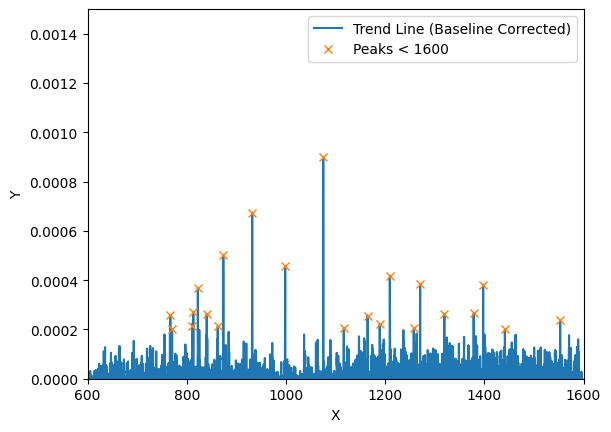

Filtered Peak X values (less than 1600): [ 766.9  770.5  811.   813.2  822.4  840.2  862.5  873.7  932.   998.5
 1075.2 1116.7 1164.6 1189.1 1209.5 1257.7 1270.5 1319.3 1378.5 1397.6
 1441.4 1552.9 1625.1 1658.2 1696.4 1717.8 1728.5 1776.9 1783.2 1798.8
 1801.8 1813.6 1824.6 1828.7 1843.8 1849.2 1851.9 1853.9 1859.5 1862.2
 1865.1 1873.6 1880.3 1885.4 1890.4 1892.4 1905.2 1907.2 1912.1 1914.3
 1922.3 1929.5 1935.  1940.7 1944.1 1946.9 1949.8 1954.7 1957.8 1963.
 1965. ]
Filtered Peak Y values (less than 1600): [0.00025899 0.00020048 0.00021594 0.00026988 0.00036843 0.00026211
 0.00021287 0.00050112 0.0006743  0.00045702 0.00090068 0.00020529
 0.00025622 0.00022101 0.00041632 0.00020405 0.00038537 0.0002627
 0.00026507 0.00038238 0.00020003 0.00023771 0.00090475 0.00022826
 0.00023844 0.00029951 0.00022148 0.00020357 0.00025257 0.00021819
 0.00041791 0.00024807 0.0002354  0.00021826 0.0002148  0.00052605
 0.00212186 0.00041517 0.0008871  0.0002949  0.00075051 0.00028427
 0.00042267 0.00

In [29]:
# Apply baseline correction (subtract the baseline)
# Using Savitzky-Golay filter to remove the baseline trend
baseline = savgol_filter(y, window_length=10000, polyorder=3)  # Smoothing the signal
corrected_y = y - baseline # Subtract baseline to remove it

# Apply a 5-point moving average to the corrected signal to get the trend line
trend_line = np.convolve(corrected_y, np.ones(5)/5, mode='valid')

# from scipy.ndimage import gaussian_filter1d

# trend_line = gaussian_filter1d(trend_line, sigma=20)

# from scipy.signal import savgol_filter

# trend_line = savgol_filter(trend_line, window_length=11, polyorder=2)

# Define the minimum peak height (this is the threshold for peak detection)
min_peak_height = 0.0002  # Change this value based on your signal

# Find the peaks in the trend line with the defined height threshold
peaks, _ = find_peaks(trend_line, height=min_peak_height, distance=20)

# Filter peaks with y-values less than 1600
filtered_peaks = peaks[trend_line[peaks] < 1600]

# Plot the data and the detected peaks
plt.plot(x[:len(trend_line)], trend_line, label='Trend Line (Baseline Corrected)')
plt.plot(x[filtered_peaks], trend_line[filtered_peaks], "x", label='Peaks < 1600')
plt.xlabel('X')
plt.xlim([600, 1600])
plt.ylim([0, 0.0015])
plt.ylabel('Y')
plt.legend()
plt.show()

# Output the filtered peak values
peak_x_values = x[filtered_peaks]
peak_y_values = trend_line[filtered_peaks]
print(f"Filtered Peak X values (less than 1600): {peak_x_values}")
print(f"Filtered Peak Y values (less than 1600): {peak_y_values}")


In [ ]:
a = pd.DataFrame(trend_line)
a.to_csv('D:/trendline.csv')

In [ ]:
target = list(peak_x_values)
target_list = [num for num in target if num > 800]

In [ ]:
df = pd.read_csv('D:/res_soluble_sorted.csv')
X = df.copy()
Y = X.pop("target")
X = np.array(X)
y = np.array(Y)

mass = [round(x * 0.1, 1) for x in range(6000, 19690)]

intensity = list(X[0])

In [ ]:
disease = [0] * len(X[0])  # Initialize the disease list for summing
healthy = [0] * len(X[0])  # Initialize the healthy list for summing

# Iterate through all entries in y
for i in range(len(y)):
    if y[i] == 1:
        # Add features to the disease group
        disease = [x + feature for x, feature in zip(disease, X[i])]
    elif y[i] == 0:
        # Add features to the healthy group
        healthy = [x + feature for x, feature in zip(healthy, X[i])]

# Now `disease` and `healthy` hold the sum of features for each group


In [ ]:
deconvolute(target_list, disease, 1)
deconvolute(target_list, healthy, 0)